Data Visualization

In [ ]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from scipy.integrate import odeint

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

In [ ]:
!pip install evojax
from evojax.util import get_params_format_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
#true params
Ka_true = 2.821 # 1/h - not in spreadsheet
Ke_true = 0.693/6.3 # 1/h
V_blood_true = 19 # L
V_gut_true = 1.3612 # L
dosage_true = 100.5348 #mg, just for reference

In [ ]:
#initial conditions
A1_init = 73.864090508375 # / V_gut_true # (mg/L) #needs to be decided
A2_init = 0 # (mg/L)

In [ ]:
# task array
task_params = np.array([[Ka_true, Ke_true, V_gut_true, V_blood_true]])

n_task = len(task_params)
n_task, task_params

(1, array([[ 2.821 ,  0.11  ,  1.3612, 19.    ]]))

Obtaining Ground Truth

In [ ]:
#caffeine equation solution generator
def caffeine(y, t, Ka, Ke, V_gut, V_blood):
    """A1 and A2 terms are not divided by V, they are just divided before being plotted"""
    A1_sys, A2_sys = y
    dydt = [-Ka* (A1_sys), Ka*(A1_sys) - Ke*(A2_sys)]
    return dydt

In [ ]:
data_A1, data_A2, data_S = [], [], [] #collect all 6 tasks (different combination of a1 a2) #data S is all zeroes
t = jnp.linspace(0, 24, 201)
t_param = t #copy for calculating ODE
t = np.expand_dims(t, axis=1) #for data_X

data_T = t
for task in task_params:

    y0 = [A1_init * V_gut_true, A2_init * V_blood_true] #must scale A1 and A2 if all resulting A1/A2 values are divided by V

    #get ODE soln for A2
    sol = odeint(caffeine, y0, t_param, args=(Ka_true, Ke_true, V_gut_true, V_blood_true))
    A1_soln = sol[:, 0:1]
    A2_soln = sol[:, 1:2]

    #divide all values by V
    data_A2.append(A2_soln/V_blood_true)
    data_A1.append(A1_soln/V_gut_true)

    #init an array of zeroes for g
    s_array = np.zeros(len(A2_soln))
    s_array = np.expand_dims(s_array, axis=1)
    data_S.append(s_array)

data_A1, data_A2, data_S = jnp.array(data_A1[0]), jnp.array(data_A2[0]), jnp.array(data_S[0])
data_y = Ka_true * data_A1 - Ke_true * data_A2
print (data_T.shape, data_A1.shape, data_A2.shape, data_S.shape, data_y.shape)

(201, 1) (201, 1) (201, 1) (201, 1) (201, 1)


Text(0, 0.5, 'A2')

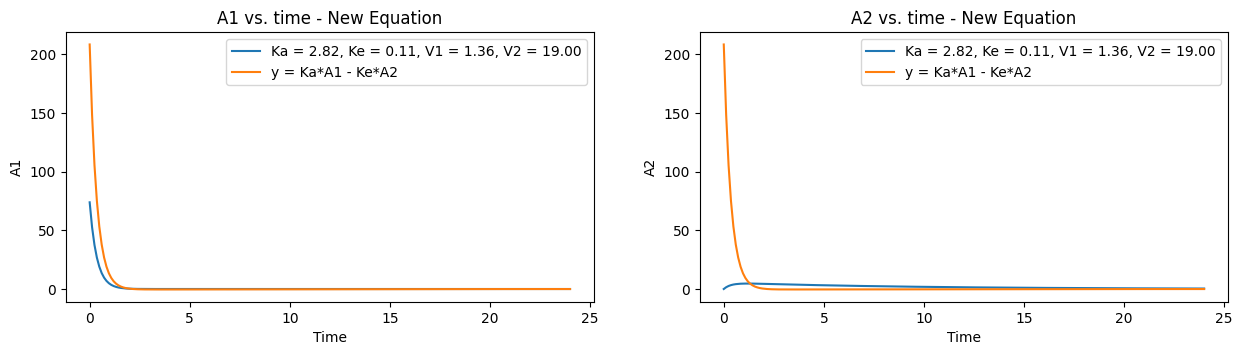

In [ ]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)


params = task_params[0]
plt.plot(data_T, data_A1, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
plt.plot(data_T, data_y, label='y = Ka*A1 - Ke*A2')

plt.title("A1 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A1");
ax1 = fig.add_subplot(1,2,2)


params = task_params[0]
plt.plot(data_T, data_A2, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
plt.plot(data_T, data_y, label='y = Ka*A1 - Ke*A2')

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A2")

## GPLearn

**Mount colab notebook to Drive**

In [ ]:
# Mounting colab notebook to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Downloading gplearn and relevant packages*

In [ ]:
# Installing gplearn
# https://gplearn.readthedocs.io/en/stable/installation.html
!pip install gplearn

*Importing relevant modules/functions*

In [ ]:
%pylab inline
from gplearn.genetic import SymbolicRegressor
# import matplotlib as plt
import numpy as np
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


*Verify working directory*

In [ ]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Caffeine/Text Files/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local/Caffeine/Text Files


Perfect data - generation, plotting, symbolic regression

In [ ]:
#Generating data sets compatible with PySR wagwarn bot dat dign
x_values = jnp.hstack([data_A1, data_A2])
y_values = data_y[:,0]

np.save('x_values_gplearn_A1A2.npy',x_values)
np.savetxt('x_values_gplearn_A1A2.txt',x_values,delimiter=' ')

np.save('y_values_gplearn_KaA1-KeA2.npy',y_values)
np.savetxt('y_values_gplearn_KaA1-KeA2.txt',y_values,delimiter=' ')

# Converting data into a .txt format compatible with matplotlib (for plotting step)
with open('xy_data_gplearn_y=KaA1-KeA2.txt', 'w') as f:
  for r in range(201):
    f.write(f'{x_values[:, 0][r]} {x_values[:, 1][r]} {y_values[r]}\n')

                0         1           2
0    7.386409e+01  0.000000  208.370599
1    5.265214e+01  1.509122  148.365670
2    3.753173e+01  2.565072  105.594861
3    2.675354e+01  3.298249   75.108928
4    1.907058e+01  3.801602   53.379928
..            ...       ...         ...
196  1.772178e-11  0.414256   -0.045568
197  8.033132e-12  0.408824   -0.044971
198  7.997448e-12  0.403463   -0.044381
199  7.916035e-12  0.398172   -0.043799
200  6.091490e-12  0.392950   -0.043225

[201 rows x 3 columns] (201, 3)


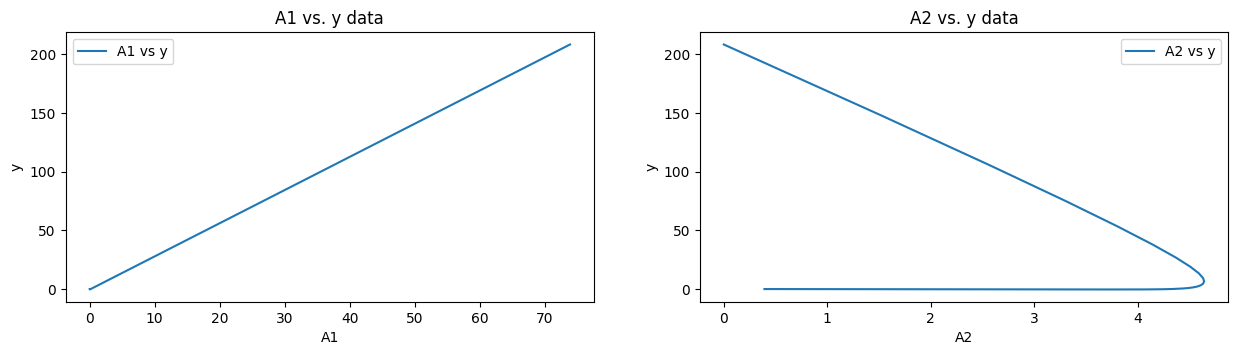

In [ ]:
# Printing perfect data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'xy_data_gplearn_y=KaA1-KeA2.txt',sep=" ",header=None)

fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(df[0], df[2], label='A1 vs y')
plt.xlabel("A1"); plt.ylabel("y");
plt.title("A1 vs. y data"); plt.legend();

ax1 = fig.add_subplot(1,2,2)
plt.plot(df[1], df[2], label='A2 vs y')
plt.xlabel("A2"); plt.ylabel("y");

plt.title("A2 vs. y data"); plt.legend();
print(df, df.shape)

In [29]:
# Running gplearn symbolic regression on perfect data (default settings)
est_gp = SymbolicRegressor(population_size=1000,
                           generations=100, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(x_values, y_values)
print(est_gp._program)

# The smaller the dataset, population_size can be increased. If the known target equation is (relatively) simple, parsimony_coefficient can be increased.
# https://github.com/trevorstephens/gplearn/blob/master/gplearn/genetic.py

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.53      1.94636e+08       15          1.04451          11.6226      4.50m
   1    12.90          671.623        9         0.434711         0.448022      1.39m
   2     8.81          13481.1       19         0.271995         0.148669      1.26m
   3     6.51          36.3929        7         0.240977          1.21395      1.17m
   4     6.44          240.818        7         0.232105             1.29      1.20m
   5     6.95          26.2587        9         0.227833          0.75744      1.22m
   6     7.28          4.87673        9         0.200234         0.993996      1.15m
   7     7.79          643.768        9         0.191522          1.06867      1.26m
   8     7.95          140.632        9         0.155389         0.902113  

Plotting solution

In [25]:
def y_soln(x0, x1):
  return (x0 + 0.661*(x0/0.816)) - 0.157

In [26]:
soln = y_soln(data_A1, data_A2)
soln.shape

(201, 1)

                0         1           2
0    7.386409e+01  0.000000  208.370599
1    5.265214e+01  1.509122  148.365670
2    3.753173e+01  2.565072  105.594861
3    2.675354e+01  3.298249   75.108928
4    1.907058e+01  3.801602   53.379928
..            ...       ...         ...
196  1.772178e-11  0.414256   -0.045568
197  8.033132e-12  0.408824   -0.044971
198  7.997448e-12  0.403463   -0.044381
199  7.916035e-12  0.398172   -0.043799
200  6.091490e-12  0.392950   -0.043225

[201 rows x 3 columns] (201, 3)


<Figure size 750x350 with 0 Axes>

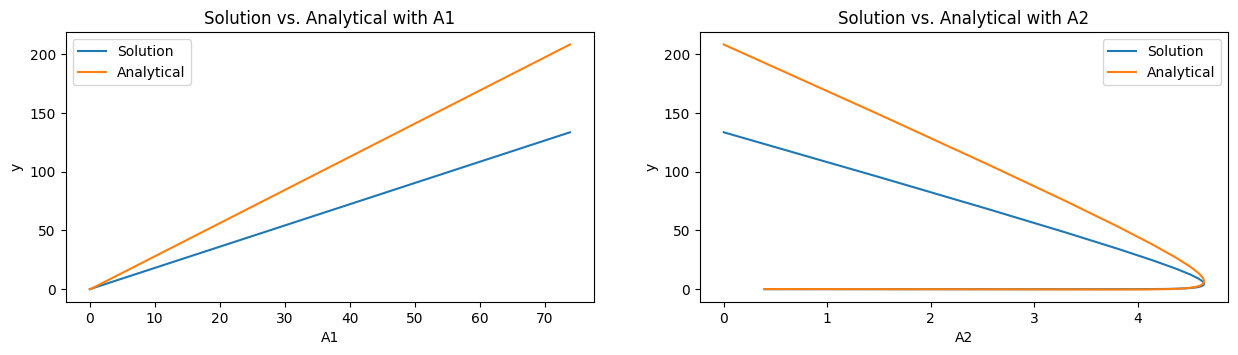

In [27]:
fig = plt.figure(figsize=(7.5, 3.5))

fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(data_A1, soln, label='Solution')
plt.plot(data_A1, data_y, label='Analytical')
plt.xlabel("A1"); plt.ylabel("y");
plt.title("Solution vs. Analytical with A1"); plt.legend();

ax1 = fig.add_subplot(1,2,2)
plt.plot(data_A2, soln, label='Solution')
plt.plot(data_A2, data_y, label='Analytical')
plt.xlabel("A2"); plt.ylabel("y");

plt.title("Solution vs. Analytical with A2"); plt.legend();
print(df, df.shape)

In [28]:
#TODO: mse between SR solution and analytical solution
print(soln.shape, data_y.shape)
jnp.mean(jnp.square(soln - data_y))

(201, 1) (201, 1)


Array(56.22427679, dtype=float64)